# Handwritten Digits Classifier - Using MNIST Dataset

#### This Notebook contains the following:

1. Data Pre-Processing (Transforming, downloading, and loading the dataset)
2. Building the Neural Network with PyTorch by using 2 ways.
    1. Initializing weights and biases.
    2. Forward pass and inference before training
3. Training the Neural Network
    1. Forward and backward passes.
    2. Inference
4. Accuracy Testing

In [1]:
# Import the used libraries

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import time
import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

## Download and load the dataset

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. The network will receive a digit image as input and predict the digit in the image.

<img src="assets\mlp_mnist.png" width="600">

To build a neural network with PyTorch, we use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. We define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), we'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets\activation.png" width="700" />

So, for this network, We'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each.
        
        # First hidden layer, 784 input units and 128 output units.
        self.fc1 = nn.Linear(784, 128)
        # Second hidden layer, 128 input units and 64 output units.
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 64 input units & 10 output units (one for each digit).
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits
            Arguments.
            ---------
            x: input tensor.
        '''
        
        x = self.fc1(x)
        x = F.relu(x)    # x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        # dim=1 means the output will be 1-D tensor (vector) ---> (10,1)
        
        return x

In [4]:
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and biases are automatically initialized for us, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, we can get them with `model.fc1.weight` for instance.

In [5]:
print("Layer\t Weights \t\t\t Bias\n")

print("fc1 \t {} \t {}\n".format(model.fc1.weight.size(), model.fc1.bias.size()))
print("fc2 \t {} \t\t {}\n".format(model.fc2.weight.size(), model.fc2.bias.size()))
print("fc3 \t {} \t\t {}\n".format(model.fc3.weight.size(), model.fc3.bias.size()))

Layer	 Weights 			 Bias

fc1 	 torch.Size([128, 784]) 	 torch.Size([128])

fc2 	 torch.Size([64, 128]) 		 torch.Size([64])

fc3 	 torch.Size([10, 64]) 		 torch.Size([10])



For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [6]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 8.7972e-03, -7.1804e-03,  8.4926e-03,  ..., -9.3371e-03,
          2.5250e-03, -1.3537e-02],
        [ 1.2592e-03, -4.0236e-03,  1.5028e-02,  ...,  3.4960e-04,
          6.7762e-03, -1.0242e-02],
        [ 1.6832e-02, -2.7022e-02, -1.3128e-02,  ..., -1.5762e-02,
         -1.2686e-03, -8.9105e-03],
        ...,
        [-1.7712e-03,  2.0405e-04, -1.2270e-02,  ..., -2.6583e-03,
         -3.9707e-03, -1.5162e-02],
        [ 7.6641e-03,  1.3084e-02,  6.1063e-03,  ...,  9.6839e-03,
         -6.7070e-03, -2.0765e-03],
        [ 3.0937e-04, -8.7736e-03, -3.1973e-03,  ..., -9.0106e-03,
          2.2801e-02, -7.9264e-03]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

In [8]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

display(images.size())
display(labels.size())

torch.Size([64, 1, 28, 28])

torch.Size([64])

In [9]:
'''
Resize images into a 1D vector, 
old shape is (batch size, color channels, width pixels, height pixels) ---> [64, 1, 28, 28]
new shape is (batch size, color channels, image pixels) ---> [64, 1, 784]
'''
images.resize_(images.shape[0], 1, 784);

In [10]:
# Forward pass through the network
img_idx = 0
propabilities = model.forward(images[img_idx,:])

print("Predicted Output probailities:\n", propabilities)
print()


# Can't call numpy() on Variable that requires grad. So we use var.detach().numpy() instead.
print("Propabilities Shape: ", propabilities.detach().numpy().shape)
print()

for i in range(propabilities.detach().numpy().shape[1]):
    print("Probability of {} is: {}".format(i, propabilities.detach().numpy()[0][i]))

Predicted Output probailities:
 tensor([[ 0.1037,  0.1029,  0.1046,  0.0977,  0.0940,  0.0975,  0.1096,
          0.1026,  0.0989,  0.0885]])

Propabilities Shape:  (1, 10)

Probability of 0 is: 0.10372467339038849
Probability of 1 is: 0.10294757038354874
Probability of 2 is: 0.10455773025751114
Probability of 3 is: 0.09771871566772461
Probability of 4 is: 0.09396900236606598
Probability of 5 is: 0.09752990305423737
Probability of 6 is: 0.10956855118274689
Probability of 7 is: 0.10255837440490723
Probability of 8 is: 0.09889143705368042
Probability of 9 is: 0.08853404223918915


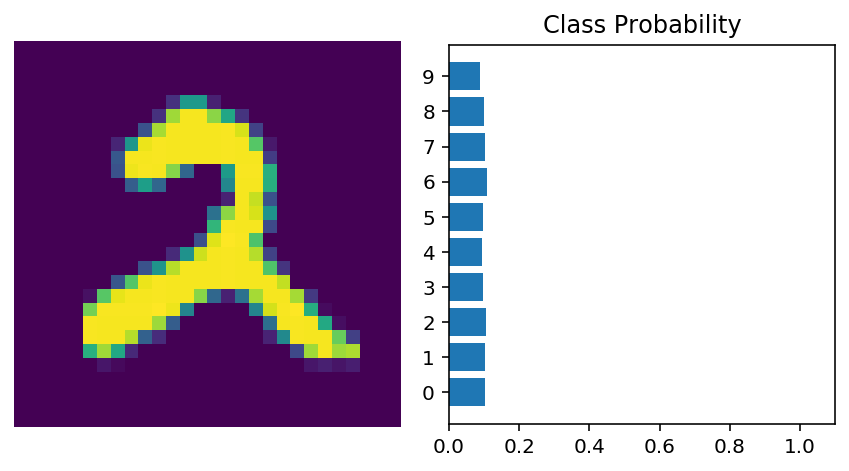

In [11]:
# use helper.view_classify to see the image but we need to change it back to 28x28 by using view().
helper.view_classify(images[img_idx,:].view(1, 28, 28), propabilities)

As we can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

## Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps our input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets\function_approx.png" width="500"/>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost function), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets\gradient_descent.png' width=350/>

### Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once we learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width="400"/>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

### Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

We'll build a network with `nn.Sequential` here. Only difference from the last part is we're not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [12]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('drop1', nn.Dropout(0.2)), 
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('drop2', nn.Dropout(0.2)), 
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

In [13]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01);

## Training the network

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

In [15]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        logits = model.forward(images)
        test_loss += criterion(logits, labels).item()

        ps = F.softmax(logits, dim=1)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [16]:
# Training the Neural Network
epochs = 40
print_every = 400
steps = 0
running_loss = 0

for e in range(epochs):
    model.train()
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/40..  Training Loss: 2.231..  Test Loss: 2.116..  Test Accuracy: 0.434
Epoch: 1/40..  Training Loss: 1.963..  Test Loss: 1.699..  Test Accuracy: 0.554
Epoch: 2/40..  Training Loss: 1.526..  Test Loss: 1.190..  Test Accuracy: 0.747
Epoch: 2/40..  Training Loss: 1.146..  Test Loss: 0.879..  Test Accuracy: 0.796
Epoch: 3/40..  Training Loss: 0.920..  Test Loss: 0.708..  Test Accuracy: 0.835
Epoch: 3/40..  Training Loss: 0.791..  Test Loss: 0.604..  Test Accuracy: 0.851
Epoch: 3/40..  Training Loss: 0.701..  Test Loss: 0.529..  Test Accuracy: 0.865
Epoch: 4/40..  Training Loss: 0.642..  Test Loss: 0.480..  Test Accuracy: 0.873
Epoch: 4/40..  Training Loss: 0.589..  Test Loss: 0.442..  Test Accuracy: 0.883
Epoch: 5/40..  Training Loss: 0.559..  Test Loss: 0.412..  Test Accuracy: 0.888
Epoch: 5/40..  Training Loss: 0.524..  Test Loss: 0.391..  Test Accuracy: 0.893
Epoch: 6/40..  Training Loss: 0.499..  Test Loss: 0.371..  Test Accuracy: 0.898
Epoch: 6/40..  Training Loss: 0.483..  T

With the network trained, we can check out it's predictions.

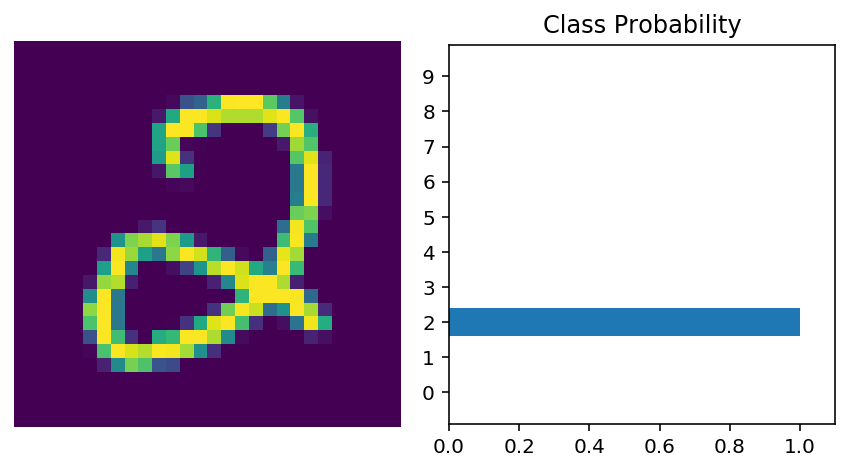

In [17]:
# Inference
images, labels = next(iter(trainloader))

img = images[0,:].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images.

## Accuracy Testing

In [18]:
# Final Testing Accuracy

model.eval()
accuracy = 0
for images, labels in iter(testloader):

        images.resize_(images.shape[0], 784)
        with torch.no_grad():
            output = model.forward(images)
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.961
